# tf.keras

[tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras) is Tensorflow's implementation of the [Keras API specification](https://keras.io/).

`tf.keras` can run any Keras-compatible code, but keep in mind:

- The `tf.keras` version in the latest Tensorflow release might not be the same as the latest `keras` version from PyPI. Check `tf.keras.__version__`.

- When [saving a model's weights](https://www.tensorflow.org/guide/keras#weights_only), `tf.keras` defaults to the [checkpoint format](https://www.tensorflow.org/guide/checkpoints). Please `save_format='h5'` to use HDF5.

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

%matplotlib inline

print(tf.__version__)
print(tf.keras.__version__)

2.0.0
2.2.4-tf


## [Option] GPU

In [2]:
isBuildWithGPUSupport = tf.test.is_built_with_gpu_support()
isGPUAvailable =  tf.test.is_gpu_available(cuda_only=False,
                                           min_cuda_compute_capability=None)

print("Tensorflow was built with GPU (i.e. CUDA or ROCm) support?:", isBuildWithGPUSupport)
print("GPU Available:", isGPUAvailable)
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow was built with GPU (i.e. CUDA or ROCm) support?: True
GPU Available: True
Num GPUs Available: 1
Found GPU at: /device:GPU:0


## Load data and preprocess data

In [3]:
def load_data():
    mnist_dataset = tf.keras.datasets.mnist.load_data()
    (x_train, y_train), (x_test, y_test) = mnist_dataset
    
    ### Preprocess the data
    # normalization
    # scale pixel value from 0:255 to 0:1
    x_train = x_train / 255.0
    x_test = x_test / 255.0
    x_train = x_train.reshape(x_train.shape[0], 28*28)
    x_test = x_test.reshape(x_test.shape[0], 28*28)

    # one-hot encode the labels
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
    
    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_data()

##  Explore the data

In [4]:
print("Training images: ", x_train.shape)
print("Training lables: ", y_train.shape)
print("Testing images: ", x_test.shape)
print("Testing labels: ", y_test.shape)

Training images:  (60000, 784)
Training lables:  (60000, 10)
Testing images:  (10000, 784)
Testing labels:  (10000, 10)


Label: 7


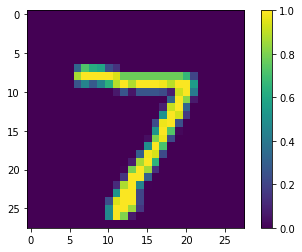

In [5]:
print("Label: {}".format(np.argmax(y_test[0])))

data = x_test[0].reshape(28, 28)

plt.figure()
plt.imshow(data)
plt.colorbar()
plt.grid(False)

## Training set and Validation Set

The built-in MNIST download function give us a spilt of 60k images for training and 10k images for test.

We split training images into the `training set (90%)` and `validation set (10%)`.

In [6]:
x_valid = x_train[54000:]
y_valid = y_train[54000:]

x_train = x_train[:54000]
y_train = y_train[:54000]

print("training set: {}".format(x_train.shape[0]))
print("validation set: {}".format(x_valid.shape[0]))

training set: 54000
validation set: 6000


## Build a simple model

 ### Sequential model
 
 In keras, you assemble `layers` to build `models`. A model is (usually) a graph of layers. The most commom `type` of model is a stack of layers: [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model.

In [7]:
# Build a simple, fully-connected network

model = tf.keras.Sequential()

model.add(Dense(689, activation='relu', input_shape=(28*28,)))
model.add(Dense(689, activation='relu'))
model.add(Dense(689, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 689)               540865    
_________________________________________________________________
dense_1 (Dense)              (None, 689)               475410    
_________________________________________________________________
dense_2 (Dense)              (None, 689)               475410    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                6900      
Total params: 1,498,585
Trainable params: 1,498,585
Non-trainable params: 0
_________________________________________________________________


### Compile the model

Before the model is ready for training, it needs a few more setting.

These are added during the model's `compile` step:

- Loss function
- Optimizer
- Metrics


In [8]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Train and evaluate

### Callbacks

- Tensorboard

```bash
$ tensorboard --logdir=logs
```

- EarlyStop
    - patience: number of epochs with no improvement after which training will be stopped.

In [9]:
# Tensorboard
tb = tf.keras.callbacks.TensorBoard(
    log_dir='./logs', 
    histogram_freq=0, write_graph=True, write_images=True)

# EarlyStop
earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3, 
    verbose=1, mode='min')

callbacks = [tb, earlyStopping]

### Start training

The model is "fit" to the training data using the `fit` method:

In [10]:
# model.fit(x_train, y_train, epochs=10, batch_size=64,
#          validation_data=(x_valid, y_valid))

# Training model with callbacks.
model.fit(x_train,
          y_train,
          epochs=10,
          batch_size=64,
          callbacks=callbacks,
          validation_data=(x_valid, y_valid))

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 6s 109us/sample - loss: 0.2037 - accuracy: 0.9378 - val_loss: 0.1111 - val_accuracy: 0.9693
Epoch 2/10
54000/54000 [==============================] - 5s 88us/sample - loss: 0.0862 - accuracy: 0.9732 - val_loss: 0.0986 - val_accuracy: 0.9720
Epoch 3/10
54000/54000 [==============================] - 5s 86us/sample - loss: 0.0639 - accuracy: 0.9805 - val_loss: 0.1024 - val_accuracy: 0.9690
Epoch 4/10
54000/54000 [==============================] - 5s 84us/sample - loss: 0.0494 - accuracy: 0.9843 - val_loss: 0.0620 - val_accuracy: 0.9823
Epoch 5/10
54000/54000 [==============================] - 4s 81us/sample - loss: 0.0404 - accuracy: 0.9870 - val_loss: 0.0815 - val_accuracy: 0.9785
Epoch 6/10
54000/54000 [==============================] - 4s 82us/sample - loss: 0.0322 - accuracy: 0.9902 - val_loss: 0.0683 - val_accuracy: 0.9832
Epoch 7/10
54000/54000 [==============================] 

### Evaluate and predict

In [11]:
result = model.evaluate(x_train, y_train, verbose=2)
print("Train Acc: ", result[1])

result = model.evaluate(x_test, y_test, verbose=2)
print("Test Acc: ", result[1])

#result = model.predict(data)

54000/1 - 3s - loss: 0.0209 - accuracy: 0.9923
Train Acc:  0.9922963
10000/1 - 1s - loss: 0.0465 - accuracy: 0.9765
Test Acc:  0.9765


## Save and restore

- Weight only
- Configuration only
- Entire model

### Entire model

The entire model can be saved to a file that contains the weight values, the model's configuration, and even optimizer's configuration. 

This allows you to checkpoint a model and resume training later: from the exact same state, without access to the original code.

In [12]:
CURR_PATH = os.getcwd()
MODEL_DIR = os.path.join(CURR_PATH, 'models/')

# create a directory for the model if it doesn't already exist
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

model.save(MODEL_DIR + 'my_nn_model.h5')

# load model
model2 = tf.keras.models.load_model(MODEL_DIR + 'my_nn_model.h5')
result = model2.evaluate(x_test, y_test, verbose=2)
print("Test Acc: ", result[1])

10000/1 - 1s - loss: 0.0465 - accuracy: 0.9765
Test Acc:  0.9765
